In [134]:
%load_ext watermark
%watermark -v -a "author: eli knaap" -d -u -p geopandas,geosnap

Author: author: eli knaap

Last updated: 2022-12-06

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.2.0

geopandas: 0.10.2
geosnap  : 0.11.0+3.gc1c51f3edecb.dirty



In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from geosnap import DataStore
from geosnap.io import get_acs
from geosnap.analyze import cluster, regionalize, find_k, find_region_k

In [5]:
import geopandas as gpd

In [6]:
store = DataStore()

/Users/knaaptime/Dropbox/projects/geosnap/geosnap/_data.py:66: UserWarning: The geosnap data storage class is provided for convenience only. The geosnap developers make no promises regarding data quality, consistency, or availability, nor are they responsible for any use/misuse of the data. The end-user is responsible for any and all analyses or applications created with the package.
  warn(


# Assessing Cluster Fit

In [52]:
chicago = get_acs(store, county_fips='17031', level='tract', years=list(range(2013, 2018)))  # without specifying a subset of years, we get everything

In [8]:
columns = ['median_household_income', 'median_home_value', 'p_asian_persons', 'p_hispanic_persons', 'p_nonhisp_black_persons', 'p_nonhisp_white_persons']

Scikit learn [provides several measures](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) for assessing the fit of a cluster model. When ground-trouth is unknown (such as the case of geodemographics), three measures, in particlar, are appropriate:

- the silhouette score
- the Calinski-Harabasz score
- the Davies Bouldin_score

## Comparing clustering algorithms

Using the same input data, here are two different geodemographic cluster results, one using kmeans, the other using hierarchical clustering with ward's linkage.

In [130]:
test, mod = cluster(chicago, columns=columns, method='kmeans', n_clusters=6, return_model=True)

In [131]:
test_ward, mod_ward = cluster(chicago, columns=columns, method='ward', n_clusters=6, return_model=True)

The `ModelResults` class returned by the cluster function provides fit measures for each solution as properties

### Silhouette Score (higher is better)

In [34]:
mod.silhouette_score

0.41165127251082295

In [35]:
mod_ward.silhouette_score

0.35971262107670565

### Calinski-Harabasz score (higher is better)

In [36]:
mod.calinski_harabasz_score

3739.476652579873

In [37]:
mod_ward.calinski_harabasz_score

3098.30153539952

### Davies Bouldin score (lower is better)

In [132]:
mod.davies_bouldin_score

0.9580583051529992

In [133]:
mod_ward.davies_bouldin_score

0.9418395695489395

The silhouette and Calinski-Harabasz scores suggest the kmeans model discovers clusters with better separation than hierarchical clustering for these data, but the Davies-Bouldin score is ever so mildly in favor of hierarchical clustering

## Choosing `k` (the number of clusters)

To help choose the an appropriate number of clusters, 

### Clustering

In [10]:
ks = find_optimal_k(chicago, columns=columns, method='kmeans', max_k=15,)

  0%|          | 0/14 [00:00<?, ?it/s]

In [11]:
ks

,best_k
silhouette_score,5
calinski_harabasz_score,5
davies_bouldin_score,3


In [12]:
ks_ward = find_optimal_k(chicago, columns=columns, method='ward', max_k=15)

  0%|          | 0/14 [00:00<?, ?it/s]

In [13]:
ks_ward

,best_k
silhouette_score,3
calinski_harabasz_score,3
davies_bouldin_score,5


In [14]:
ks = find_k(chicago, columns=columns, method='kmeans', min_k=10, max_k=25, return_table=True)

  0%|          | 0/16 [00:00<?, ?it/s]

passing the argument `return_table=True` will return the full table of fit metrics indexed by $k$

In [ ]:
ks.head()

In [8]:
import matplotlib.pyplot as plt

Plotting each measure on the y-axis, and $k$ on the x-axis shows how the fit metric changes as the number of clusters increases

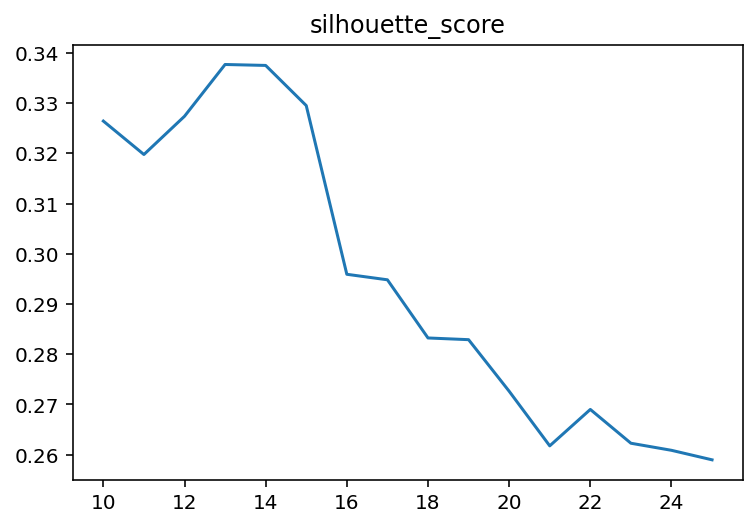

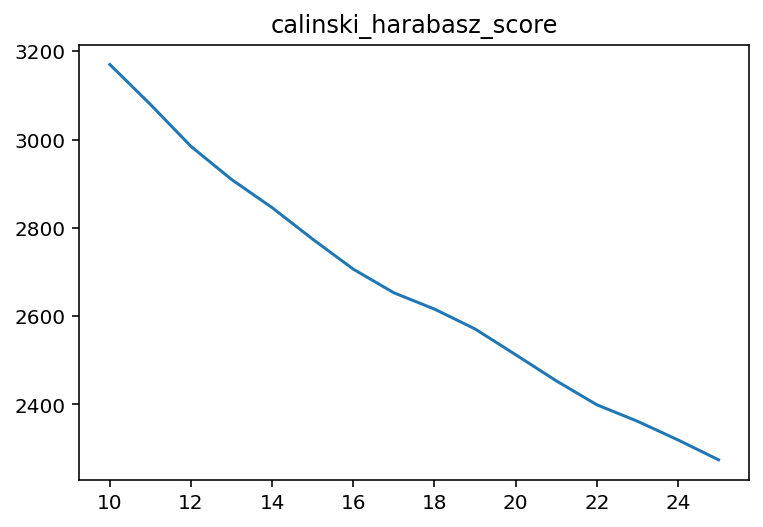

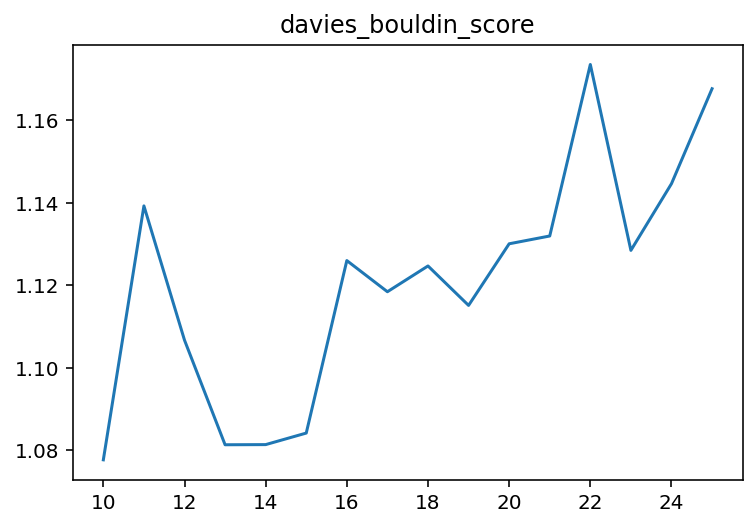

In [15]:
for i in ks.columns:
    f, ax = plt.subplots()
    ks[i].plot(title=i)

In this case 13 clusters or so looks appropriate

### Regionalization

In [112]:
from sklearn.preprocessing import MinMaxScaler

In [114]:
test_ward_spatial, mod_ward_spatial = regionalize(chicago, columns=columns, method='ward_spatial', n_clusters=6, return_model=True, scaler=MinMaxScaler())

<AxesSubplot:>

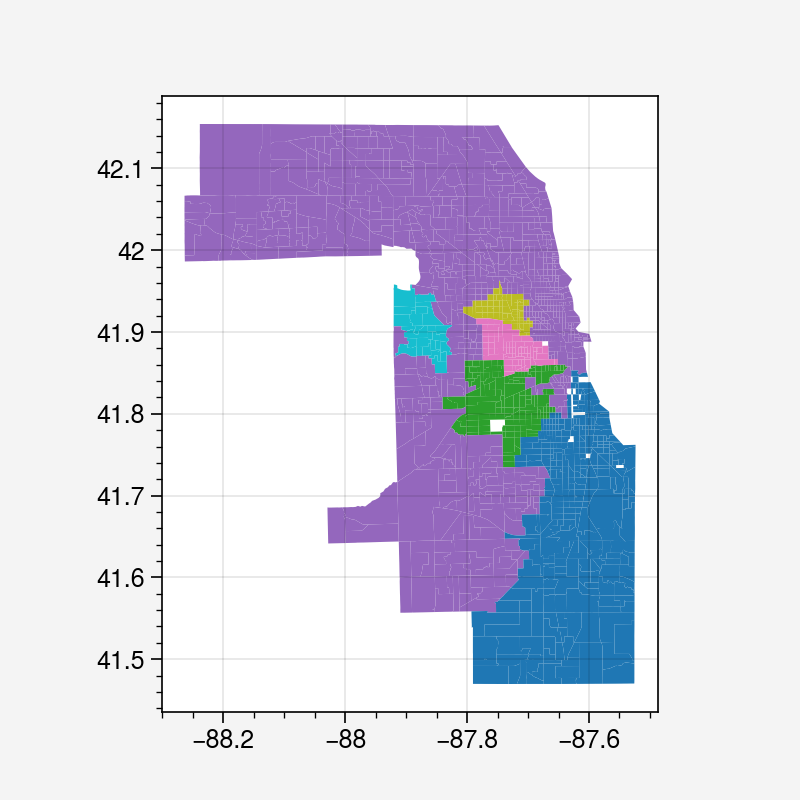

In [117]:
test_ward_spatial[test_ward_spatial.year==2017].plot('ward_spatial')

In [42]:
from geosnap.visualize import plot_timeseries

SubplotGrid(nrows=1, ncols=4, length=4)

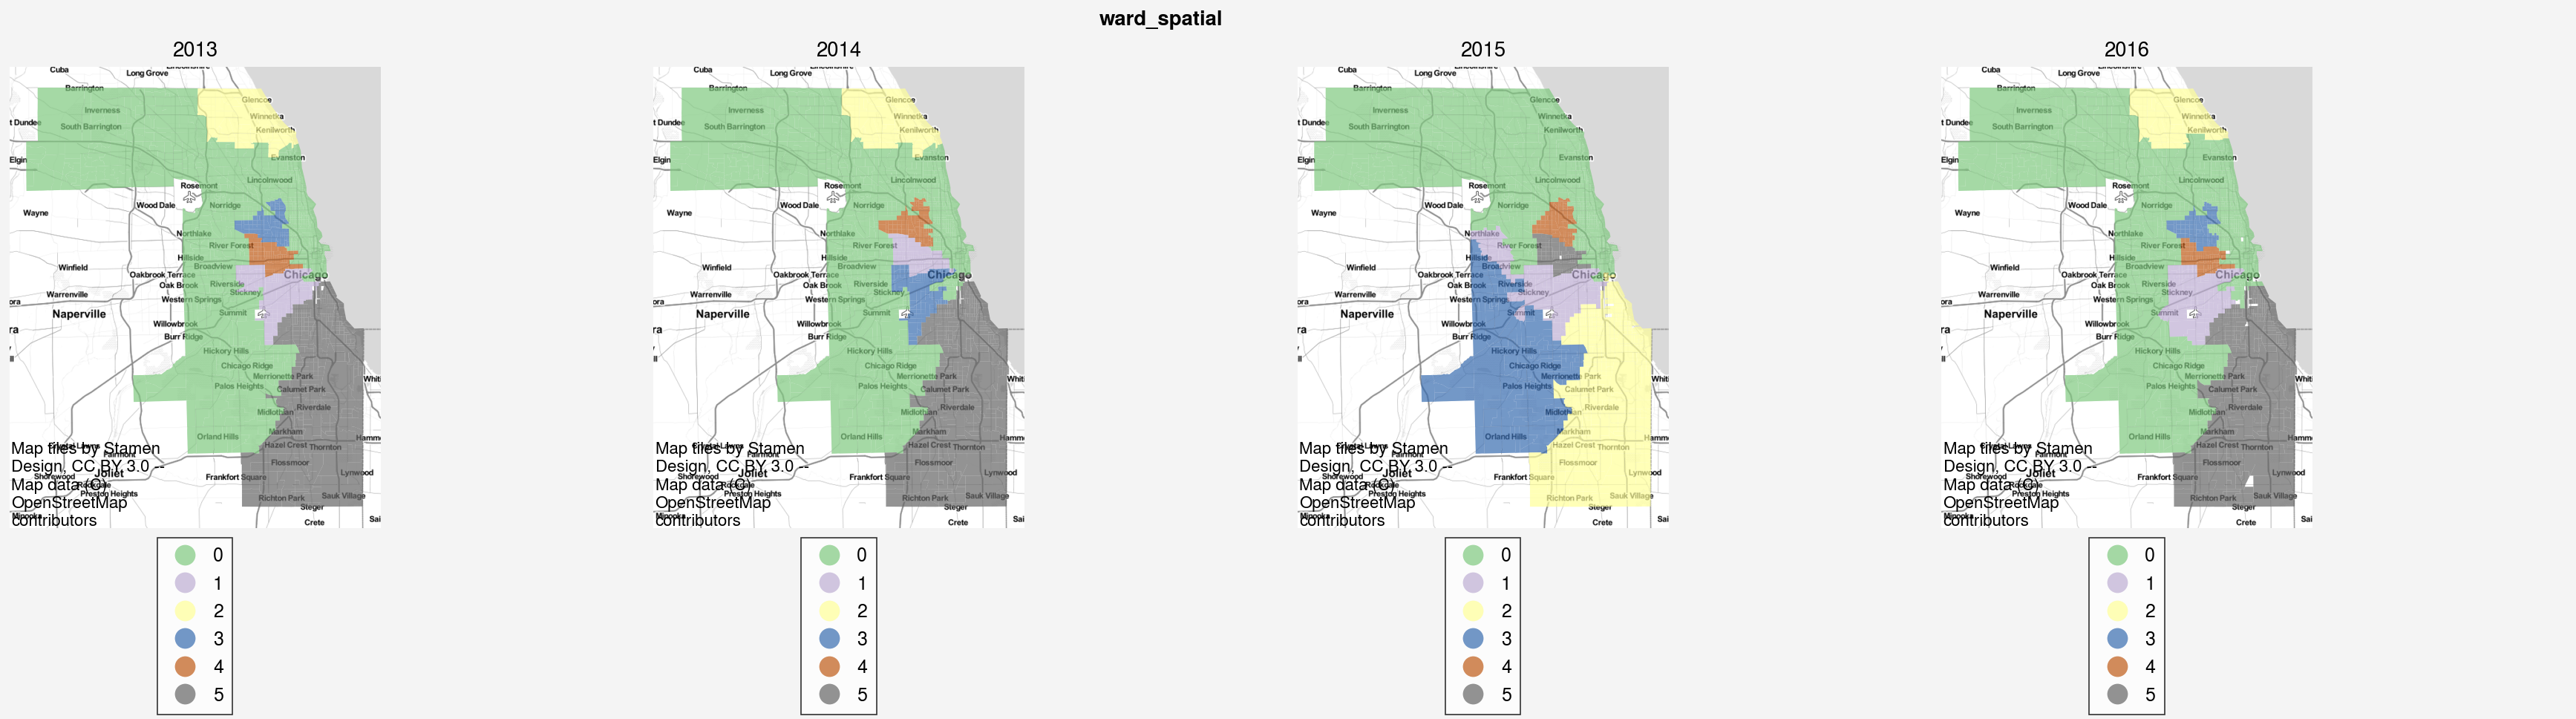

In [43]:
plot_timeseries(test_ward_spatial, 'ward_spatial', categorical=True)

An analogous function is provided for determining the best number of $k$ regions according to each metric

In [99]:
reg_k = find_region_k(chicago, columns=columns, method='ward_spatial', min_k=5, max_k=20)

  0%|          | 0/19 [00:00<?, ?it/s]

We might use this to examine whether a region is getting more integrated over time. For example if the best fitting $k$ is increasing over time, then it suggests an increasingly-complex grouping structure is necessary to describe the study area. Put differently, this would suggest the emergence of "new neighborhoods" and the need to cut the region into a greater number of homogenous places.

In [100]:
reg_k

,silhouette_score,calinski_harabasz_score,davies_bouldin_score
time_period,,,
2013.0,2.0,2.0,2.0
2014.0,2.0,2.0,2.0
2015.0,2.0,2.0,2.0
2016.0,2.0,2.0,2.0
2017.0,2.0,2.0,2.0


Using a sequence of the 5-year ACS in Chicagoland, things look pretty stable (and small--only two regions get the "best" metric in all cases)

And by passing `return_model=True`, we again get back the full table of fit metrics. We can use this table, for example, to compare the difference between using the standard (z-score) scaler versus a min-max scaler, often used in non-geodemographic clustering applications

In [110]:
# StandardScaler is the default
t_table = find_region_k(
    chicago,
    columns=columns,
    method="ward_spatial",
    return_table=True,
    min_k=5,
    max_k=100,
)

  0%|          | 0/96 [00:00<?, ?it/s]

In [118]:
t_table2 = find_region_k(
    chicago,
    columns=columns,
    method="ward_spatial",
    return_table=True,
    min_k=5,
    max_k=100,
    scaler=MinMaxScaler(),
)

  0%|          | 0/96 [00:00<?, ?it/s]

<AxesSubplot:xlabel='k'>

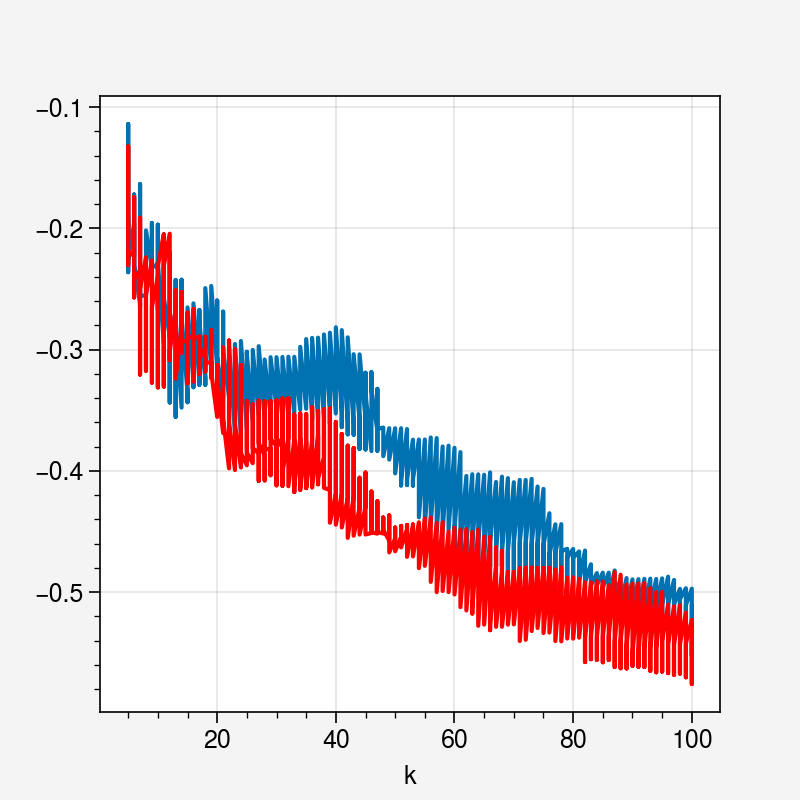

In [127]:
ax =t_table.silhouette_score.plot()
t_table2.silhouette_score.plot(ax=ax, c='red')

I think those local maxima look interesting (e.g. around 18 and around 40 in the blue graph). Before those, there is a steady score increase, so these might be different natural cut points in the neighborhood structure

it also looks like the standard scaler outperforms the minmax scaler at just about every level of $k$

<AxesSubplot:xlabel='k'>

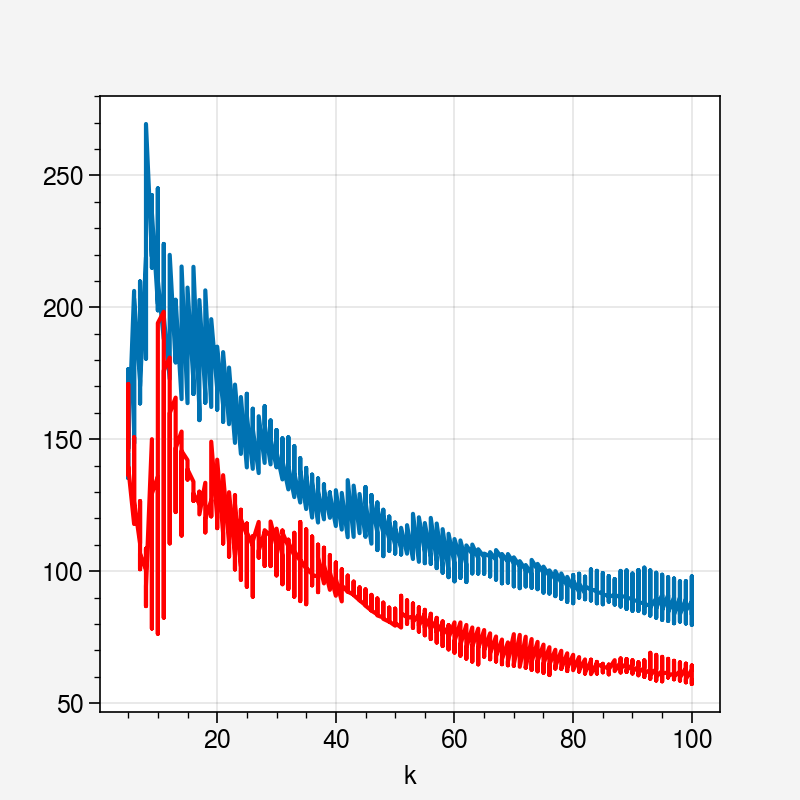

In [128]:
ax = t_table.calinski_harabasz_score.plot()
t_table2.calinski_harabasz_score.plot(ax=ax, c='red')

<AxesSubplot:xlabel='k'>

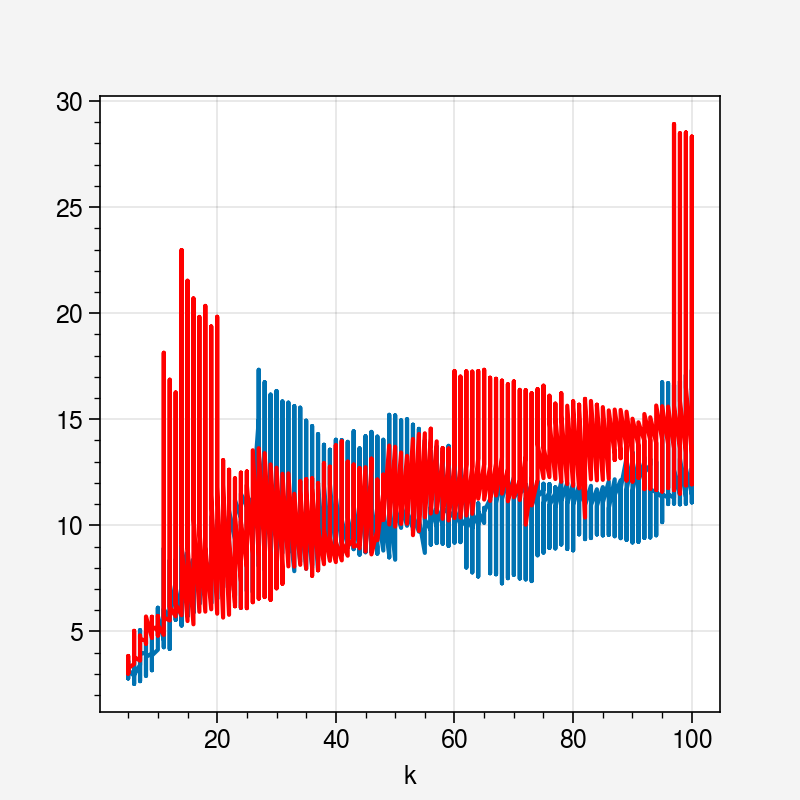

In [129]:
ax = t_table.davies_bouldin_score.plot()
t_table2.davies_bouldin_score.plot(ax=ax, c='red')
# lower is better here